## *1. Import semua library yang dibutuhkan*

In [131]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM

##*2. Lakukan pengecekan data meliputi info dataframe, sampel dataset, dan pengecekan jika ada nilai yang kosong*

In [132]:
df = pd.read_csv('prices.csv')
print(df.info())
print('='*30)
print(df.head(2), df.tail(2))
print('='*30)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
None
                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   

      volume  
0  2163600.0  
1  2386400.0                          date symbol       open      close        low   high  \
851262  2016-12-30 00:00:00    AIV  44.730000  45.450001  44.410000  45.59   
851263  2016-12-30 00:00:00    FTV  54.200001

##*3. Filter dataframe, ambil kolom yang hanya diperlukan saja untuk keperluan kita, lakukan pengecekan*

In [133]:
df = df[['date','symbol','close']]
df.head(1)

,date,symbol,close
0,2016-01-05 00:00:00,WLTW,125.839996


In [134]:
df = df[(df.symbol=='AMZN')]
df

,date,symbol,close
284,2010-01-04,AMZN,133.899994
751,2010-01-05,AMZN,134.690002
1219,2010-01-06,AMZN,132.250000
1687,2010-01-07,AMZN,130.000000
2155,2010-01-08,AMZN,133.520004
...,...,...,...
848799,2016-12-23,AMZN,760.590027
849299,2016-12-27,AMZN,771.400024
849799,2016-12-28,AMZN,772.130005
850299,2016-12-29,AMZN,765.150024


In [135]:
del df['symbol']
df.head(1)

,date,close
284,2010-01-04,133.899994


##*4. Penamaan kembali (rename), terhadap kolom - kolom agar memudahkan pemrosesan data*

In [136]:
df.rename(columns={'date' : 'Date','close': 'Close Price'},inplace=True)
df.head(1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Date,Close Price
284,2010-01-04,133.899994


##*5. Membuat duplikat dataframe, digunakan untuk indexing tahun dan agar dataframe asli tidak terganggu*

In [137]:
ndf = df
ndf['Date'] = pd.to_datetime(ndf['Date'])
ndf.set_index('Date',inplace = True)
ndf.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1762, freq=None)

In [138]:
ndf['Date']= ndf.index.year
ndf.head(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Close Price,Date
Date,,
2010-01-04,133.899994,2010


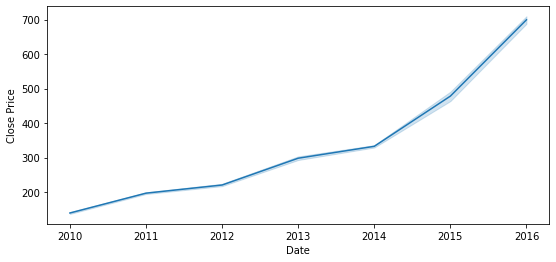

In [139]:
plt.figure(figsize=(9,4))
sns.lineplot(x = "Date" , y = "Close Price",data=ndf)
plt.show()

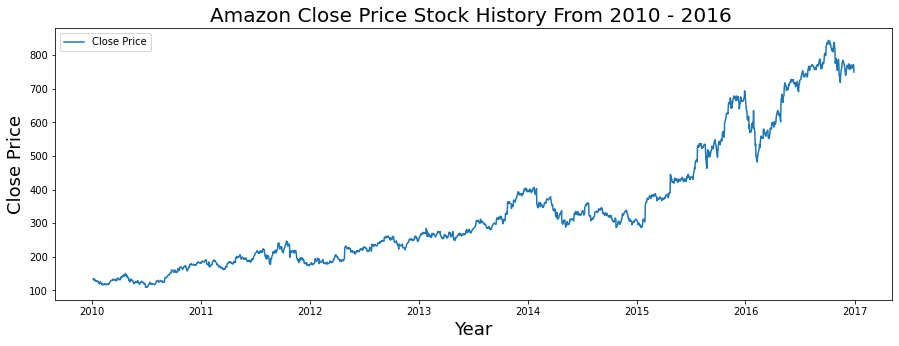

In [140]:
plt.figure(figsize=(15,5))
plt.plot(df['Close Price'])
plt.title('Amazon Close Price Stock History From 2010 - 2016 ', fontsize=20)
plt.xlabel('Year', fontsize= 18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(['Close Price'],loc='upper left')
plt.show()

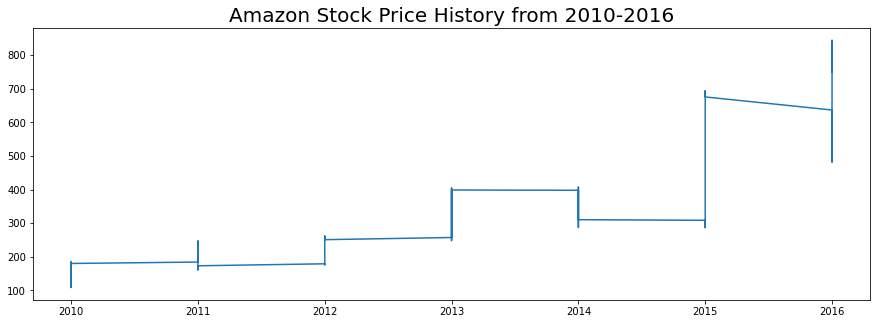

In [141]:
date = df['Date'].values
close_price  = df['Close Price'].values
df = df.values
     
plt.figure(figsize=(15,5))
plt.plot(date, close_price)
plt.title('Amazon Stock Price History from 2010-2016',
              fontsize=20);

In [142]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)

## *6. Proses Normalisasi Data*

In [143]:
min_max_scaler = MinMaxScaler()
train_scale = min_max_scaler.fit_transform(train.reshape(-1,1))
test_scale = min_max_scaler.fit_transform(test.reshape(-1,1))
train_scale, test_scale

(array([[0.01326591],
        [0.99737724],
        [0.01368031],
        ...,
        [1.        ],
        [0.21716962],
        [1.        ]]), array([[0.03904987],
        [0.99935593],
        [0.04127836],
        [0.99935593],
        [0.04028003],
        [0.99935593],
        [0.04269528],
        [0.99935593],
        [0.04389328],
        [0.99935593],
        [0.0462763 ],
        [0.99935593],
        [0.04614752],
        [0.99935593],
        [0.04479495],
        [0.99935593],
        [0.03375565],
        [0.99935593],
        [0.02003053],
        [0.99935593],
        [0.        ],
        [0.99935593],
        [0.00193221],
        [0.99935593],
        [0.02408816],
        [0.99935593],
        [0.03542376],
        [0.99935593],
        [0.03519191],
        [0.99935593],
        [0.03189428],
        [0.99935593],
        [0.02136376],
        [0.99935593],
        [0.03038714],
        [0.99935593],
        [0.02663223],
        [0.99935593],
        [0.0229481

##*7. Membagi / split dataframe menjadi data training dan data testing*

In [144]:
train_size = int(len(close_price) * 0.8)
test_size = len(date) - train_size
train, test = df[0:train_size], df[train_size:len(df)]
print(len(train),len(test))

1409 353


##*8. Gunakan TimeSeriesGenerator dapat membantu memudahkan pemrosesan model*
The Keras deep learning library provides the TimeseriesGenerator to automatically transform both univariate and multivariate time series data into samples, ready to train deep learning models.(https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)

In [145]:
look_back = 20
train_generator = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=30)     
test_generator = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)

##*9. Membangun arsitektur model menggunakan Sequential, 1 LSTM layer, dan 4 Dense layer*

In [146]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

##*10. Kriteria pada submission ini mengharuskan model memiliki nilai MAE < 10% skala data. Berikut perintah untuk mengetahui nilai ambang batas (threshold) yang tepat untuk data yang digunakan., dan perbandingan menghitung mae dengan cara yang lain*

In [147]:
treshold_mae = (ndf['Close Price'].max() - ndf['Close Price'].min()) * 10/100
max = ndf['Close Price'].max()
min = ndf['Close Price'].min()
x = (max - min) * (10 / 100)
print(x, treshold_mae)

73.57499840000001 73.5749984


##*11. Penggunaan Callbacks untuk menghemat waktu pelatihan model ketika model sudah mencapai target yang diinginkan*

In [148]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< 0.005):
      self.model.stop_training = True
      print(f'\n Nilai MAE < 10% Skala Data')
callbacks = myCallback()

##*12. Setting Optimizer menggunakan Adam dengan learning_rate=0.001, berikut dengan pelatihan model, target mae < 0.005, epoch=40*

In [149]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit_generator(train_generator, epochs=40, validation_data= test_generator, verbose=2, callbacks=[callbacks])

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


94/94 - 5s - loss: 0.1240 - mae: 0.4581 - val_loss: 0.0942 - val_mae: 0.4276 - 5s/epoch - 54ms/step
Epoch 2/40
94/94 - 4s - loss: 0.1027 - mae: 0.4474 - val_loss: 0.0722 - val_mae: 0.3684 - 4s/epoch - 39ms/step
Epoch 3/40
94/94 - 4s - loss: 0.0547 - mae: 0.2637 - val_loss: 0.1184 - val_mae: 0.3900 - 4s/epoch - 39ms/step
Epoch 4/40
94/94 - 3s - loss: 0.0175 - mae: 0.1298 - val_loss: 0.0226 - val_mae: 0.1283 - 3s/epoch - 27ms/step
Epoch 5/40
94/94 - 4s - loss: 0.0062 - mae: 0.0643 - val_loss: 0.0340 - val_mae: 0.1621 - 4s/epoch - 38ms/step
Epoch 6/40
94/94 - 4s - loss: 0.0059 - mae: 0.0625 - val_loss: 0.0020 - val_mae: 0.0445 - 4s/epoch - 39ms/step
Epoch 7/40
94/94 - 4s - loss: 0.0011 - mae: 0.0312 - val_loss: 0.0052 - val_mae: 0.0492 - 4s/epoch - 38ms/step
Epoch 8/40
94/94 - 4s - loss: 0.0025 - mae: 0.0433 - val_loss: 0.0017 - val_mae: 0.0421 - 4s/epoch - 39ms/step
Epoch 9/40
94/94 - 4s - loss: 6.9932e-04 - mae: 0.0269 - val_loss: 0.0026 - val_mae: 0.0399 - 4s/epoch - 39ms/step
Epoch 10

##*13. Plot loss dan akurasi pada saat training dan validation.*

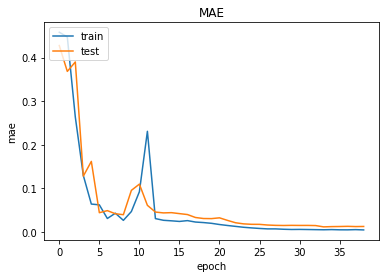

In [150]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

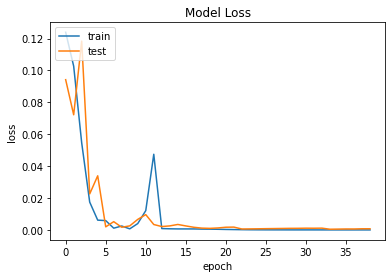

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()